In [1]:
pip install datasets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvid

In [2]:
pip show datasets

Name: datasets
Version: 3.6.0
Summary: HuggingFace community-driven open-source library of datasets
Home-page: https://github.com/huggingface/datasets
Author: HuggingFace Inc.
Author-email: thomas@huggingface.co
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: dill, filelock, fsspec, huggingface-hub, multiprocess, numpy, packaging, pandas, pyarrow, pyyaml, requests, tqdm, xxhash
Required-by: torchtune
Note: you may need to restart the kernel to use updated packages.


In [3]:
from datasets import load_dataset


ds = load_dataset("fancyzhx/ag_news")

# Inspect the dataset to ensure it's loaded properly
print(ds)


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Epoch [1/100], Loss: 0.2072
Epoch [2/100], Loss: 0.2072
Epoch [3/100], Loss: 0.2072
Epoch [4/100], Loss: 0.2072
Epoch [5/100], Loss: 0.2072
Epoch [6/100], Loss: 0.2072
Epoch [7/100], Loss: 0.2072
Epoch [8/100], Loss: 0.2072
Epoch [9/100], Loss: 0.2072
Epoch [10/100], Loss: 0.2072
Epoch [11/100], Loss: 0.2072
Epoch [12/100], Loss: 0.2072
Epoch [13/100], Loss: 0.2072
Epoch [14/100], Loss: 0.2072
Epoch [15/100], Loss: 0.2072
Epoch [16/100], Loss: 0.2072
Epoch [17/100], Loss: 0.2072
Epoch [18/100], Loss: 0.2072
Epoch [19/100], Loss: 0.2072
Epoch [20/100], Loss: 0.2072
Epoch [21/100], Loss: 0.2072
Epoch [22/100], Loss: 0.2072
Epoch [23/100], Loss: 0.2072
Epoch [24/100], Loss: 0.2072
Epoch [25/100], Loss: 0.2072
Epoch [26/100], Loss: 0.2072
Epoch [27/100], Loss: 0.2072
Epoch [28/100], Loss: 0.2072
Epoch [29/100], Loss: 0.2072
Epoch [30/100], Loss: 0.2072
Epoch [31/100], Loss: 0.2072
Epoch [32/100], Loss: 0.2072
Epoch [33/100], Loss: 0.2072
Epoch [34/100], Loss: 0.2072
Epoch [35/100], Loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.0715
Davies-Bouldin Index: 2.3910


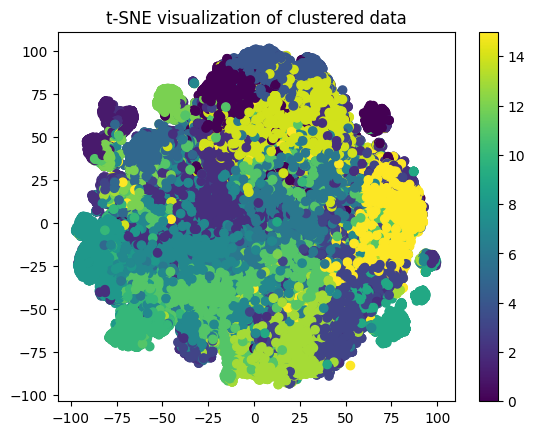

In [6]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)

tokenized_datasets = ds.map(tokenize_function, batched=True, batch_size=16)  # Specify batch_size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained("bert-base-uncased").to(device)

# Convert text to embeddings
def get_embeddings(examples):
    embeddings = []
    batch_size = 32  # Adjust based on GPU memory capacity

    for i in range(0, len(examples['text']), batch_size):
        batch = examples['text'][i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to GPU

        with torch.no_grad():
            outputs = model(**inputs)

        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.extend(batch_embeddings)  # Collect embeddings

    return {'embeddings': embeddings}

# Apply embeddings extraction
embedded_datasets = tokenized_datasets.map(get_embeddings, batched=True)

# Define Autoencoder Model for Clustering
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        latent = self.encoder(x)
        decoded = self.decoder(latent)
        return decoded

# Change the input_dim based on PCA output (64 after PCA)
input_dim = 64  # After PCA, the reduced dimensionality is 64
latent_dim = 32  # Latent space size (can adjust based on your use case)
autoencoder_model = Autoencoder(input_dim, latent_dim).to(device)  # Move autoencoder to GPU

# Training the Autoencoder

# Prepare data for training
train_embeddings = torch.tensor([item['embeddings'] for item in embedded_datasets['train']]).to(device)

# Apply PCA for dimensionality reduction (on CPU)
pca = PCA(n_components=64)  # Reduce to 64 dimensions
train_embeddings = pca.fit_transform(train_embeddings.cpu().numpy())  # Apply PCA on CPU

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model.parameters(), lr=0.001)

# Training loop with gradient accumulation to manage memory
epochs = 100
batch_size = 32  # Adjust based on GPU memory capacity

for epoch in range(epochs):
    autoencoder_model.train()
    optimizer.zero_grad()

    # Process the data in batches
    for i in range(0, len(train_embeddings), batch_size):
        batch = train_embeddings[i:i+batch_size]
        batch = torch.tensor(batch).to(device)  # Move batch to GPU

        reconstructed = autoencoder_model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()

        if (i + 1) % batch_size == 0:  # Update after each batch
            optimizer.step()
            optimizer.zero_grad()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    torch.cuda.empty_cache()  # Clear GPU memory after each epoch

# Extract Latent Embeddings for Clustering

autoencoder_model.eval()
with torch.no_grad():
    latent_embeddings = autoencoder_model.encoder(torch.tensor(train_embeddings).to(device))

# Apply K-Means Clustering

from sklearn.cluster import KMeans

# Move latent embeddings back to CPU for KMeans
latent_embeddings = latent_embeddings.cpu().numpy()

# Apply K-Means to the latent space
kmeans = KMeans(n_clusters=16, random_state=42)
kmeans.fit(latent_embeddings)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Silhouette Score
sil_score = silhouette_score(latent_embeddings, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

# Davies-Bouldin Index
db_score = davies_bouldin_score(latent_embeddings, cluster_labels)
print(f"Davies-Bouldin Index: {db_score:.4f}")

# Visualization using t-SNE

tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(latent_embeddings)


plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar()
plt.title("t-SNE visualization of clustered data")
plt.show()

